# Processing and downsampling the B cells and T cells into a counts matrix to be input into Splatter

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

/home/ahsvargo/miniconda3/envs/r35py37/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
from scipy.stats import rankdata
import scipy.sparse as spsp

Would Louvain clustering work?

In [3]:
import os
os.environ['LD_LIBRARY_PATH']

'/home/ahsvargo/lib:/sw/arcts/centos7/hpc-utils/lib:/sw/arcts/centos7/R/3.3.3/lib64/R/lib:/sw/arcts/centos7/openmpi/1.10.2-gcc-4.8.5/lib:/home/ahsvargo/lib:/home/ahsvargo/lib'

In [4]:
"libigraph.so.0" in os.listdir("/home/ahsvargo/lib")

True

Import the data

In [16]:
bpath = "./twoGroups/bCells/filtered_matrices_mex/hg19/"
tpath = "./twoGroups/tCells/filtered_matrices_mex/hg19/"

This caching is fine.  Both data sets are cached into the same directory (the working directory for this notebook).

In [17]:
%%time
bdata = sc.read(bpath + "matrix.mtx", cache=True).T
bdata.var_names = pd.read_csv(bpath + 'genes.tsv', header=None, sep='\t')[1]
bdata.obs_names = pd.read_csv(bpath + 'barcodes.tsv', header=None)[0]

tdata = sc.read(tpath + "matrix.mtx", cache=True).T
tdata.var_names = pd.read_csv(tpath + 'genes.tsv', header=None, sep='\t')[1]
tdata.obs_names = pd.read_csv(tpath + 'barcodes.tsv', header=None)[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1.05 s, sys: 172 ms, total: 1.22 s
Wall time: 1.24 s


In [18]:
bdata.var_names_make_unique()
tdata.var_names_make_unique()

In [19]:
bdata.X.shape

(10085, 32738)

In [9]:
%%time
sc.pp.filter_genes(bdata, min_counts=1)  # only consider genes with more than 1 count

CPU times: user 138 ms, sys: 38.5 ms, total: 176 ms
Wall time: 174 ms


In [10]:
bdata.X.shape

(10085, 15858)

In [32]:
bcells = random.sample(range(bdata.X.shape[0]), 5000)

In [23]:
bdata[bcells].write_loom("bCells.loom")

Okay, I can't get `loomR` installed on our system.  So... we will just hack this.  Annoyingly

In [33]:
np.savetxt("splatter-bCells/allGenes/9/bCells.dat", bdata[bcells].X.toarray().astype('int'), fmt='%i', delimiter=' ')

In [12]:
bdata.X.nnz/(bdata.X.shape[0]*bdata.X.shape[1])

0.016157420312098825

In [11]:
bdata.X.shape

(10085, 15858)

In [12]:
import random

In [10]:
np.where(bdata.X.sum(axis=0)[0]==0)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([    0,     1,     2, ..., 32735, 32736, 32737]))

In [16]:
np.asarray(bdata.X.sum(axis=0))[0].nonzero()[0].shape

(15858,)

## Try to preprocess the bCells set to see if the gene names are the same

They are.  We can filter the genes with the following and then use filtered genes for full evaluations.  In the above, we do this.

In [8]:
%%time
sc.pp.filter_genes(bdata, min_counts=1)  # only consider genes with more than 1 count

CPU times: user 136 ms, sys: 13.1 ms, total: 149 ms
Wall time: 148 ms


In [10]:
%%time
sc.pp.normalize_per_cell(bdata)  

CPU times: user 92.4 ms, sys: 0 ns, total: 92.4 ms
Wall time: 91.2 ms


In [12]:
%%time
filter_result = sc.pp.filter_genes_dispersion(
    bdata.X, flavor='cell_ranger', n_top_genes=5000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 0.40 GB, difference +0.40 GB
CPU times: user 150 ms, sys: 26 ms, total: 176 ms
Wall time: 337 ms


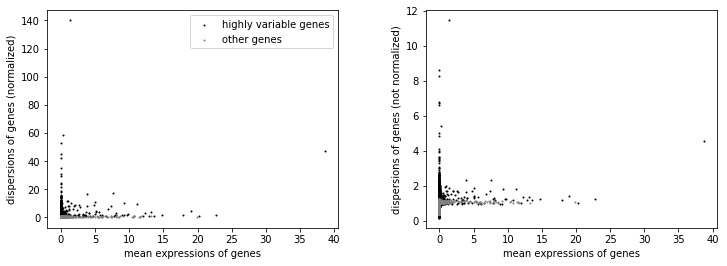

In [13]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

Reload the data so that we don't save normalized stuff

In [14]:
%%time
bdata = sc.read(bpath + "matrix.mtx", cache=True).T
bdata.var_names = pd.read_csv(bpath + 'genes.tsv', header=None, sep='\t')[1]
bdata.obs_names = pd.read_csv(bpath + 'barcodes.tsv', header=None)[0]
bdata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 454 ms, sys: 62.8 ms, total: 517 ms
Wall time: 552 ms


Get the filter created above

In [15]:
%%time
sc.pp.filter_genes(bdata, min_counts=1)  # only consider genes with more than 1 count
bdata = bdata[:, filter_result.gene_subset]  # filter genes

CPU times: user 203 ms, sys: 17.5 ms, total: 220 ms
Wall time: 221 ms


Save the full data set (which is much smaller since it has only 5000 genes)

In [16]:
np.savetxt("bCells.dat", bdata.X.toarray().astype('int'), fmt='%i', delimiter=' ')

In [17]:
bdata.X.shape

(10085, 4999)

## Check to see that this bulk data matches the full zheng data, at least a little bit

This will probably use quite a bit of memory.  We are going concatenate all of the data together into one `AnnData` object and then project via umap.  I want to see if it all fits in or if I am just doing something kind of random (in which case, I may as well just use one of the bulk samples for my splatter simulation).

Load the full zheng dataset so that we can concatenate stuff

In [13]:
%%time
path= "/home/ahsvargo/turbo/scData/zheng17/filtered_matrices_mex/hg19/"

## Load all genes
adata = sc.read_h5ad(path + "cache/matrix.h5ad").T

CPU times: user 5.55 s, sys: 1.16 s, total: 6.71 s
Wall time: 7.09 s


In [14]:
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
adata.obs['bulk_labels'] = pd.read_csv(path + 'zheng17_bulk_lables.txt', header=None)[0].values
adata.obs['louv_labels'] = pd.Series( np.load(path + 'zheng17_yVec_lvals.npz')['y'], dtype="category", index=adata.obs.index)

Make sure that you are working with the unprocessed bCell data for the following.

In [20]:
fdata = adata.concatenate(bdata,tdata, join='inner')

/home/ahsvargo/miniconda3/envs/r35py37/lib/python3.7/site-packages/anndata/base.py:1839: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat(out_obss)


In [21]:
type(fdata.obs['batch'])

pandas.core.series.Series

In [22]:
fdata.obs['bulk_labels'].loc[ fdata.obs['batch'] == '1'] = "bCells"
fdata.obs['bulk_labels'].loc[ fdata.obs['batch'] == '2'] = "tCells"

fdata.obs['louv_labels'].loc[ fdata.obs['batch'] == '1'] = "bCells"
fdata.obs['louv_labels'].loc[ fdata.obs['batch'] == '2'] = "tCells"

/home/ahsvargo/miniconda3/envs/r35py37/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
# sometimes some errors in the previous command but in-depth checks look okay to me
#fdata.obs['bulk_labels'].loc[ fdata.obs['batch'] == '1']

In [23]:
fdata.obs

,batch,bulk_labels,louv_labels
AAACATACACCCAA-1-0,0,CD8+ Cytotoxic T,2
AAACATACCCCTCA-1-0,0,CD8+/CD45RA+ Naive Cytotoxic,3
AAACATACCGGAGA-1-0,0,CD4+/CD25 T Reg,1
AAACATACTAACCG-1-0,0,CD19+ B,7
AAACATACTCTTCA-1-0,0,CD4+/CD25 T Reg,0
AAACATACTGGATC-1-0,0,CD4+/CD25 T Reg,0
AAACATACTGTCTT-1-0,0,CD4+/CD45RO+ Memory,2
AAACATACTTCTAC-1-0,0,CD8+ Cytotoxic T,2
AAACATTGCTGCTC-1-0,0,CD8+/CD45RA+ Naive Cytotoxic,3
AAACATTGCTTCGC-1-0,0,CD8+ Cytotoxic T,4


A sparse matrix, so we shouldn't need to worry about filling with 0s (can't be storing Nan's realisitcally)

In [24]:
type(fdata.X)

scipy.sparse.csr.csr_matrix

Carry out the full analysis to view the new umap.  Hopefully things look okay.

In [25]:
%%time
sc.pp.filter_genes(fdata, min_counts=1)  # only consider genes with more than 1 count

CPU times: user 1.33 s, sys: 529 ms, total: 1.85 s
Wall time: 1.85 s


In [26]:
%%time
sc.pp.normalize_per_cell(fdata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(
    fdata.X, flavor='cell_ranger', n_top_genes=5000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 1.19 GB, difference +1.19 GB
CPU times: user 2.26 s, sys: 2.28 s, total: 4.54 s
Wall time: 4.72 s


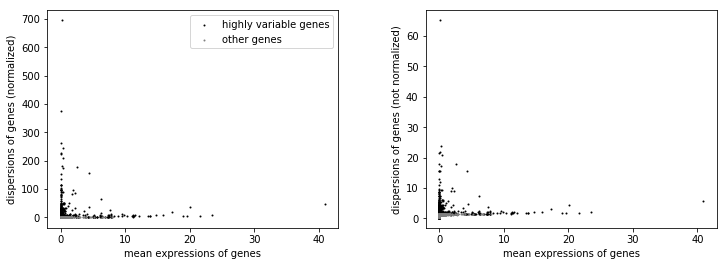

In [27]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

In [28]:
%%time
fdata = fdata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(fdata)  # need to redo normalization after filtering
sc.pp.log1p(fdata)  # log transform: X = log(X + 1)
sc.pp.scale(fdata)  # center and make the data have unit variance

CPU times: user 2.76 s, sys: 2.94 s, total: 5.7 s
Wall time: 5.7 s


### PCA

In [29]:
%%time
sc.tl.pca(fdata, n_comps=55)
sc.logging.print_memory_usage()

Memory usage: current 3.01 GB, difference +1.82 GB
CPU times: user 1min 39s, sys: 32.2 s, total: 2min 12s
Wall time: 43.1 s


### Generate neighbours and umap

In [30]:
%%time
sc.pp.neighbors(fdata, n_neighbors=25, n_pcs=50)
sc.logging.print_memory_usage()

Memory usage: current 2.81 GB, difference -0.21 GB
CPU times: user 56.6 s, sys: 16.9 s, total: 1min 13s
Wall time: 55.5 s


In [31]:
%%time
sc.tl.umap(fdata)
sc.logging.print_memory_usage()

Memory usage: current 2.81 GB, difference +0.01 GB
CPU times: user 3min 17s, sys: 4.77 s, total: 3min 22s
Wall time: 2min 58s


In [32]:
fdata

AnnData object with n_obs × n_vars = 88873 × 5000 
    obs: 'batch', 'bulk_labels', 'louv_labels', 'n_counts'
    var: 'n_counts'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

### Visualize everything

... storing 'bulk_labels' as categorical
... storing 'louv_labels' as categorical


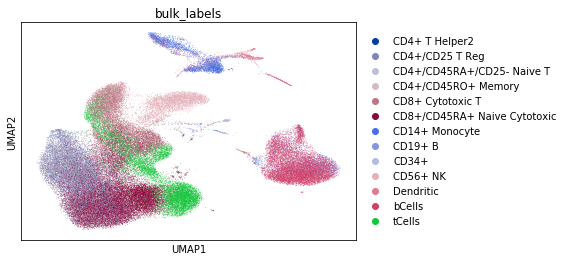

In [33]:
sc.pl.umap(fdata, color='bulk_labels')

In [79]:
fdata.loc[fdata.obs['bulk_labels'] == 'CD19+ B']

AttributeError: 'AnnData' object has no attribute 'loc'

It appears that they two groups are not paticularly close to the original data.  I suppose that there are probably some batch effects going on here.  Let's try to restrict to the relevant subgroups.

In [34]:
bulkBind = fdata.obs.loc[ fdata.obs['bulk_labels'] == 'CD19+ B'].index.tolist()
newBind = fdata.obs.loc[ fdata.obs['bulk_labels'] == 'bCells'].index.tolist()

saving figure to file ./figures/umapbcells.pdf


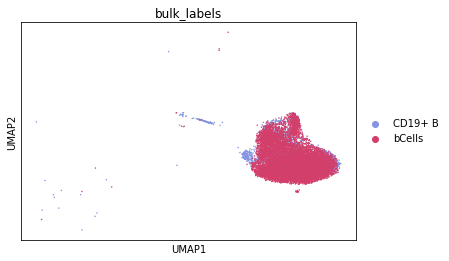

In [37]:
sc.pl.umap(fdata[bulkBind+newBind], color='bulk_labels', save='bcells.pdf')

The b cells look quite good actually!  The t cells were supposed to be the cytotoxic t cells.

In [95]:
bulkTind = fdata.obs.loc[ fdata.obs['bulk_labels'] == 'CD8+ Cytotoxic T'].index.tolist()
moreTind = fdata.obs.loc[ fdata.obs['bulk_labels'] == 'CD8+/CD45RA+ Naive Cytotoxic'].index.tolist()
newTind = fdata.obs.loc[ fdata.obs['bulk_labels'] == 'tCells'].index.tolist()

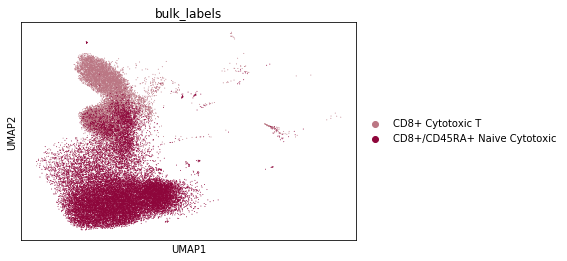

In [96]:
sc.pl.umap(fdata[bulkTind+moreTind], color='bulk_labels')

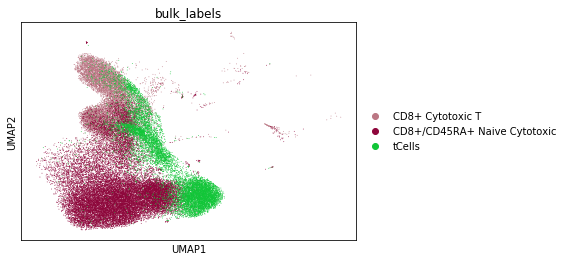

In [97]:
sc.pl.umap(fdata[bulkTind + moreTind + newTind], color='bulk_labels')

It's not terrible, but it's not great.  It's quite shifted.  But this is with no correction whatsoever.

Since the bCells match so well but the tCells are shifted, we continue our analysis with only the bCells.  Can simulate differential expression with Splatter - don't know if I should combine the bulk samples of bCells and tCells without any batch correction (since they are apparantly coming from different experiments).